In [387]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [148]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [453]:
# Time to load in the data
data = pd.read_csv("data.csv")
energies = pd.read_csv("subopt_attributes.csv")
energies["sequence"] = energies.Sequence.str.slice(29, -32).str.replace("U", "T")
big_table = pd.merge(energies, data, on='sequence', how="inner")

#columns list needed when we add data later
cols = list(energies.columns)
cols.remove('Sequence')
cols.remove('sequence')
#now we want to add the ABA column to big_table
perfect_sequence = "CCATAGAGAGGTTATCCGCTCA"
PERFECT_KD = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['kd']
PERFECT_SEQ = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['Sequence']
big_table['ABA'] = (big_table.kd/PERFECT_KD).apply(np.log)
big_table.head()
#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output
# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables

def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
# to help analyze results
def display(predicted, actual):
    plt.scatter(predicted, actual)
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title("predicted vs actual")
    plt.show()
    #now we build the table that we will use for regressions
#think of data_matrix as input and output variable as output
seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        #print(seq, perfect_sequence)
        if seq_aba_pairs[seq] < 6:
            pruned_output.append(seq_aba_pairs[seq])
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            for coord in coords:
                row[get_position(coord)] = 1
            #append the value of the energy levels
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
            #row.append(np.exp(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100']))
            row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
            #row.extend(list((np.array(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))**2)))
            pruned_combined_data_matrix.append(row)
    X = np.array(pruned_combined_data_matrix)
    y = np.array(pruned_output)
    return X, y

In [454]:
X, y = create_matrix()
X_add = []
for row in X:
    add_row = []
    for gene in range(int(len(X[0])/9)):
        add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                       sum(row[gene*9: (gene+1)*9])])
    for gene in range(int(len(X[0])/27)):
        add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                       sum(row[gene*27: (gene+1)*27])])
    for gene in range(int(len(X[0])/54)):
        add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                       sum(row[gene*54: (gene+1)*54])])
    for gene in range(int(len(X[0])/108)):
        add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                       sum(row[gene*99: (gene+1)*99])])
    for i in range(9):
        sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
        add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
        #add_row.extend([max(sub_list)**2, min(sub_list)**2,sum(sub_list)**2])
    X_add.append(add_row)
X_add = np.array(X_add)
X = np.append(X, X_add, axis=1)

In [126]:
X[-1]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [63]:
model = Sequential()

In [64]:
#model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))

In [336]:
def hinge(x, exp=1):
    return min(x, 6**exp)
vhinge = np.vectorize(hinge)

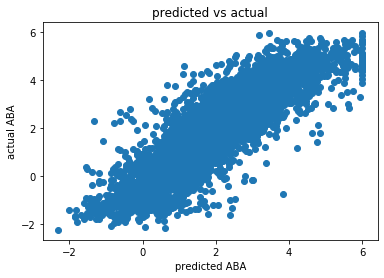

In [190]:
x = preprocessing.scale(X)
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(X, y)
huber.coef_
#This looks like the tightest regression so far
predicted_output = X @ huber.coef_ + huber.intercept_
display(vhinge(predicted_output), y)

In [191]:
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

correlation is 0.8597276204330918


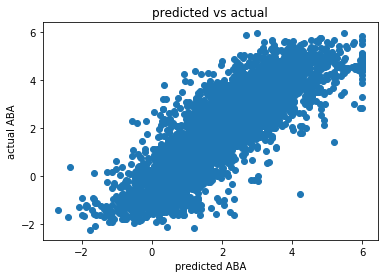

correlation is 0.8400224251693794


In [144]:
reg = linear_model.LinearRegression()
reg.fit(X, y)
#This looks like the tightest regression so far
predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y)
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

In [132]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [458]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
train_x = X[:2000]
test_x = X[2000:]
train_y = y[:2000]
test_y = y[2000:]

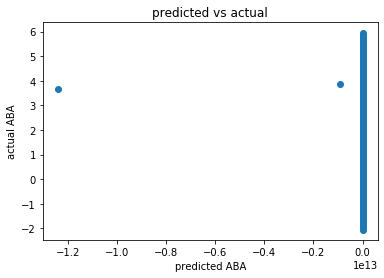

correlation is -0.019913870301540508


In [143]:
'''
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(train_x, train_y)
huber.coef_
#This looks like the tightest regression so far
predicted_output = test_x @ huber.coef_ + huber.intercept_
'''
reg = linear_model.LinearRegression()
reg.fit(train_x, train_y)
#This looks like the tightest regression so far
predicted_output = test_x @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), test_y)
corr, p_value = pearsonr(vhinge(predicted_output), test_y)
print("correlation is",corr)

In [11]:
energies.loc[0]['Sequence'].replace('U', 'T')

'GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGTTATACACGCTCACCGAGATCGGAAGAGCACACGTCTGAACTCCA'

In [12]:
energies.loc[0]['sequence']

'CCATAGAGAGGTTATACACGCTCA'

In [13]:
energies.loc[1]['Sequence'].replace('U', 'T')

'GGGAATGGATCCACATCTACGAATTCGTACCAGAGAGTGGTTATCCGCTCACCGAGATCGGAAGAGCACACGTCTGAACTCCA'

In [10]:
energies.loc[1]['sequence']

'CCAGAGAGTGGTTATCCGCTCA'

In [14]:
energies["head"] = energies.Sequence.str.slice(26, 29).str.replace("U", "T")

In [23]:
energies['head'].unique()

array(['GTA'], dtype=object)

In [20]:
energies["tail"] = energies.Sequence.str.slice(-32, -29).str.replace("U", "T")

In [22]:
energies['tail'].unique()

array(['CCG'], dtype=object)

In [24]:
energies

,Sequence,Vienna,MFold,sequence,head,tail
0,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUAC...,-15.700000,-17.60,CCATAGAGAGGTTATACACGCTCA,GTA,CCG
1,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAGAGAGUGGUUAUCC...,-23.600000,-20.97,CCAGAGAGTGGTTATCCGCTCA,GTA,CCG
2,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,-20.900000,-20.10,CCATAGATGAGGTTATCCGCGTCA,GTA,CCG
3,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGACGGUGUAU...,-22.500000,-22.80,CCATAGAGACGGTGTATCCGCTCA,GTA,CCG
4,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,-22.400000,-23.80,CCATAGAGAGGTTATCCGTTCT,GTA,CCG
...,...,...,...,...,...,...
4931,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUCUAUC...,-18.600000,-16.42,CCATAGAGAGGTCTATCCGCTCA,GTA,CCG
4932,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGGGGUUAUCC...,-20.100000,-21.30,CCATGGAGGGGTTATCCGCTCA,GTA,CCG
4933,GGGAAUGGAUCCACAUCUACGAAUUCGUACUAUAGAGAGGUUAGCC...,-16.200001,-18.60,CTATAGAGAGGTTAGCCGCTCA,GTA,CCG
4934,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGACGGUUAUC...,-18.799999,-20.70,CCATAGAGACGGTTATCCTGCTCA,GTA,CCG


In [26]:
energies = pd.read_csv("subopt_attributes.csv")

In [27]:
energies.head()

,mfold_opt,mfold_worst,mfold_mean,mfold_samples,mfold_std,mfold_skew,mfold_median,vienna_opt,vienna_worst,vienna_mean,vienna_samples,vienna_std,vienna_skew,vienna_median,vienna_worst_100,vienna_mean_100,Sequence
0,-22.80,-21.10,-22.00,3,0.697615,0.212073,-22.10,-21.9,-16.9,-17.643825,2097,0.751334,-1.611854,-17.4,-19.200001,-19.856,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGAGGUUAUCC...
1,-21.47,-21.47,-21.47,1,0.000000,0.000000,-21.47,-23.9,-18.9,-19.735792,1288,0.838893,-1.601279,-19.5,-21.100000,-21.820,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGAUCCGC...
2,-15.80,-15.20,-15.50,2,0.300000,0.000000,-15.50,-15.5,-10.5,-11.225309,10127,0.724902,-1.580592,-11.0,-13.700000,-14.197,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...
3,-17.67,-17.67,-17.67,1,0.000000,0.000000,-17.67,-19.5,-14.5,-15.347548,4894,0.831892,-1.490905,-15.1,-17.700001,-18.254,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...
4,-15.99,-15.99,-15.99,1,0.000000,0.000000,-15.99,-15.7,-10.7,-11.386458,4630,0.699062,-1.641765,-11.2,-13.400000,-13.914,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUACUCUCCAAUAGG...


In [84]:
cols = list(energies.columns)
cols.remove('Sequence')
cols.remove('sequence')

In [98]:
list(big_table[cols].loc[0])

[-22.8,
 -21.1,
 -22.0,
 3.0,
 0.6976149845485446,
 0.2120728607559804,
 -22.1,
 -21.899999618530273,
 -16.899999618530273,
 -17.643824508659716,
 2097.0,
 0.7513340633970687,
 -1.6118542048529023,
 -17.399999618530273,
 -19.200000762939453,
 -19.85599983215332]

In [85]:
cols

['mfold_opt',
 'mfold_worst',
 'mfold_mean',
 'mfold_samples',
 'mfold_std',
 'mfold_skew',
 'mfold_median',
 'vienna_opt',
 'vienna_worst',
 'vienna_mean',
 'vienna_samples',
 'vienna_std',
 'vienna_skew',
 'vienna_median',
 'vienna_worst_100',
 'vienna_mean_100']

In [92]:
pruned_combined_data_matrix.head()

AttributeError: 'list' object has no attribute 'head'

In [115]:
len(X[0])

343

In [120]:
X_normal = preprocessing.scale(X)

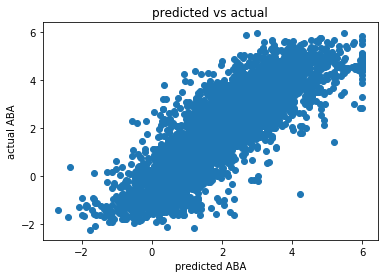

correlation is 0.8400224251693794


In [184]:
reg = linear_model.LinearRegression()
reg.fit(X, y)
#This looks like the tightest regression so far
predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y)
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

In [185]:
pos = reg.coef_[:22*9]

In [186]:
pos

array([-1.88411275e-01,  3.94135103e-01,  7.64095934e-01,  6.72530917e-01,
        3.19727243e-01,  1.40507861e+13,  1.70062276e+00,  9.01807795e-01,
       -1.00534208e+00,  1.08731577e-01, -1.27464674e+13,  1.25172481e+00,
        1.71387214e-01,  7.53864935e-01,  3.45849750e+12,  1.91731729e+00,
       -1.74117741e+00,  2.98048771e+00,  2.80130794e+13, -1.19248423e+00,
        1.94686904e+00,  4.78691208e-01,  1.80088435e+13, -1.37818002e+13,
        1.62307177e+00,  6.01215776e-01,  5.09610039e-01,  2.05238609e-01,
        1.01008290e+00,  7.67999475e-01,  3.54096710e+13,  8.19142812e-01,
       -1.44074044e+12,  9.88769531e-01, -4.88771274e+13,  1.06933594e+00,
       -1.75065922e+13,  7.30438232e-01,  6.65985107e-01, -5.81054688e-02,
       -5.00635866e+12, -1.31789209e+13,  1.20532227e+00,  5.51757812e-01,
        1.56347656e+00,  1.29882812e-01,  9.82299805e-01,  2.51321785e+13,
        1.15344238e+00,  8.92578125e-01, -2.66009693e+13,  7.09228516e-01,
        5.65429688e-01,  

In [154]:
huber.coef_[:22*9]

array([ 0.02373943,  0.6088391 ,  0.91617117,  0.81413075,  0.27552891,
        0.        ,  1.82756879,  0.86709997, -0.96564057,  0.19755179,
        0.        ,  1.35173457,  0.25341728,  0.83361588,  0.        ,
        2.2424562 , -1.97866663,  1.30550494,  0.        , -1.10220186,
        2.06248564,  0.52552796,  0.        ,  0.        ,  1.56357935,
        0.64333409,  0.60390982,  0.30252601,  1.07435418,  0.85341921,
        0.        ,  0.99129068,  0.        ,  1.09145998,  0.        ,
        1.18145301,  0.        ,  0.80050205,  0.729084  ,  0.2013717 ,
        0.        ,  0.        ,  1.22675309,  0.68892758,  1.61551221,
        0.22438621,  1.05607469,  0.        ,  1.1926968 ,  0.94936737,
        0.        ,  0.77648735,  0.68828033,  1.6154152 ,  0.        ,
        1.77231453,  0.21153389,  3.16921322,  0.        ,  0.        ,
        0.49639701,  0.61309105,  1.52534841,  0.26784559,  0.12822441,
        0.        ,  0.6058752 ,  0.43429031,  0.        ,  0.52

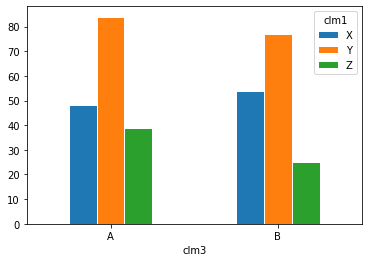

In [158]:
#create toy dataframe
np.random.seed(1234)
df = pd.DataFrame({"clm1": ["X", "Y", "Z", "X", "Y", "Z"], "clm2": np.random.randint(1, 100, 6), "clm3": ["A", "A", "A", "B", "B", "B"]})

#rearrange dataframe and plot
df.pivot(index = "clm3", columns = "clm1", values = "clm2").plot.bar(edgecolor = "white")
plt.xticks(rotation = 0)
plt.show()

In [161]:
df.pivot(index = "clm3", columns = "clm1", values = "clm2")

clm1,X,Y,Z
clm3,,,
A,48,84,39
B,54,77,25


In [162]:
df

,clm1,clm2,clm3
0,X,48,A
1,Y,84,A
2,Z,39,A
3,X,54,B
4,Y,77,B
5,Z,25,B


In [ ]:
pd.DataFrame({"clm1": ["X", "Y", "Z", "X", "Y", "Z"], "clm2": np.random.randint(1, 100, 6)

In [164]:
get_action(55)

'INS C'

In [211]:
def hist_plot(arr):
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr))],
                        "Action": [get_action(elt) for elt in range(len(arr))],
                            "Val": arr})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white", figsize=(20,10))
    plt.xticks(rotation = 0)
    plt.show()
    #return df

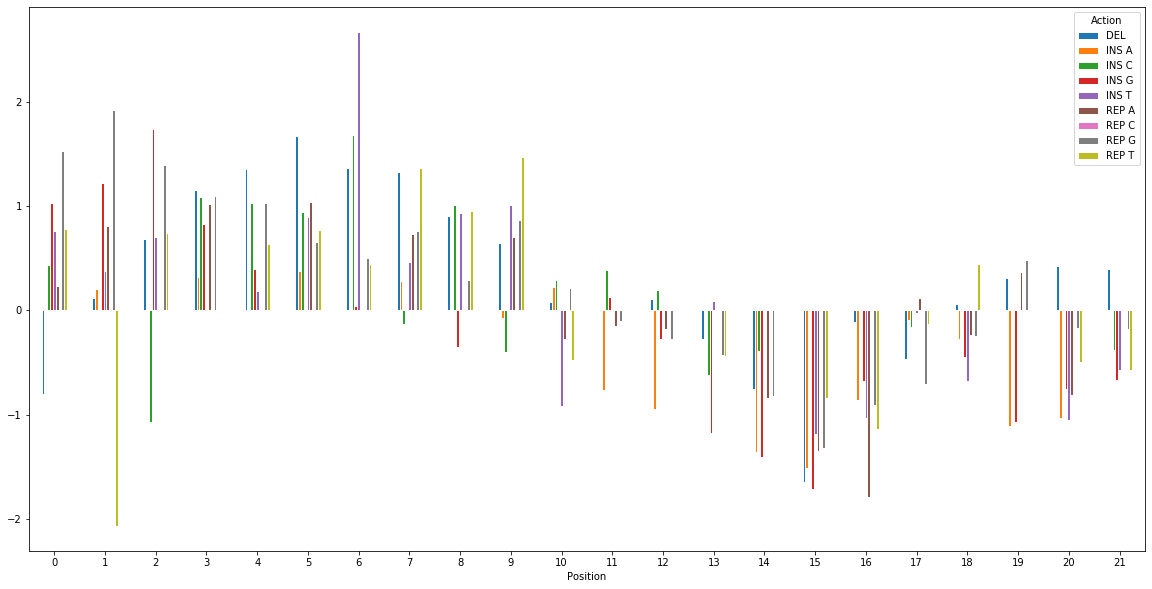

In [192]:
x = hist_plot(huber.coef_[:22*9])


array([ 0.01431972,  0.42982878,  1.0292908 ,  0.75627036,  0.23294845,
        0.        ,  1.52664943,  0.78204389, -0.80553277,  0.20817456,
        0.        ,  1.21935246,  0.38060739,  0.80345923,  0.        ,
        1.92217875, -2.06844171,  0.11293477,  0.        , -1.06855347,
        1.73571524,  0.70515461,  0.        ,  0.        ,  1.39014364,
        0.74311867,  0.68355571,  0.32109008,  1.08251822,  0.82149327,
        0.        ,  1.02202554,  0.        ,  1.09065199,  0.        ,
        1.14931525,  0.        ,  1.0317287 ,  0.39626017,  0.18833232,
        0.        ,  0.        ,  1.02420437,  0.63338608,  1.35545652,
        0.37879939,  0.94098407,  0.        ,  0.88869038,  1.03765702,
        0.        ,  0.65569578,  0.77250975,  1.67164418,  0.        ,
        1.67453612,  0.04236246,  2.66688421,  0.        ,  0.        ,
        0.50475074,  0.44376437,  1.36172587,  0.2847251 , -0.13421403,
        0.        ,  0.46689985,  0.7344956 ,  0.        ,  0.75

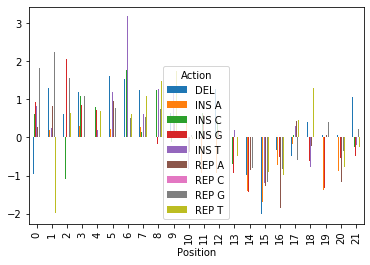

In [177]:
x.pivot(index = "Position", columns = "Action", values = "Val").plot.bar()

(array([4.750e+02, 1.139e+03, 2.110e+03, 1.109e+03, 1.000e+02, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-2.21777406, -0.40544432,  1.40688543,  3.21921517,  5.03154491,
         6.84387466,  8.6562044 , 10.46853414, 12.28086389, 14.09319363,
        15.90552337]),
 <a list of 10 Patch objects>)

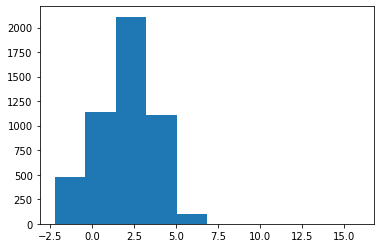

In [197]:
plt.hist(big_table.ABA)

In [206]:
X, y = create_matrix()

In [208]:
X = preprocessing.scale(X)

In [209]:
huber = HuberRegressor(alpha=1.0, epsilon=1.35)
huber.fit(X, y)
huber.coef_

array([ 3.73030004e-02,  4.80061060e-04,  1.25007970e-01,  7.29984643e-02,
        4.86144225e-02,  0.00000000e+00,  1.39132229e-01,  9.79801526e-02,
       -8.27702213e-02,  5.06985848e-02,  0.00000000e+00,  1.33068041e-01,
        4.10663008e-02,  1.14762532e-01,  0.00000000e+00,  2.03453747e-01,
       -1.92800303e-01,  3.97070358e-02,  0.00000000e+00, -1.06059127e-01,
        1.54389594e-01,  7.40795434e-02,  0.00000000e+00,  0.00000000e+00,
        1.44773525e-01,  7.14570148e-02,  4.82454046e-02,  6.79791892e-02,
        1.06637036e-01,  9.97430875e-02,  0.00000000e+00,  1.47600914e-01,
        0.00000000e+00,  1.60321717e-01,  0.00000000e+00,  1.01015494e-01,
        0.00000000e+00,  9.21294362e-02,  6.57365789e-02,  3.97309060e-02,
        0.00000000e+00,  0.00000000e+00,  1.45083557e-01,  8.39624346e-02,
        9.18635937e-02,  5.43425353e-02,  1.28584970e-01,  0.00000000e+00,
        7.57748103e-02,  1.70983284e-01,  0.00000000e+00,  1.57876929e-01,
        1.68598572e-01,  

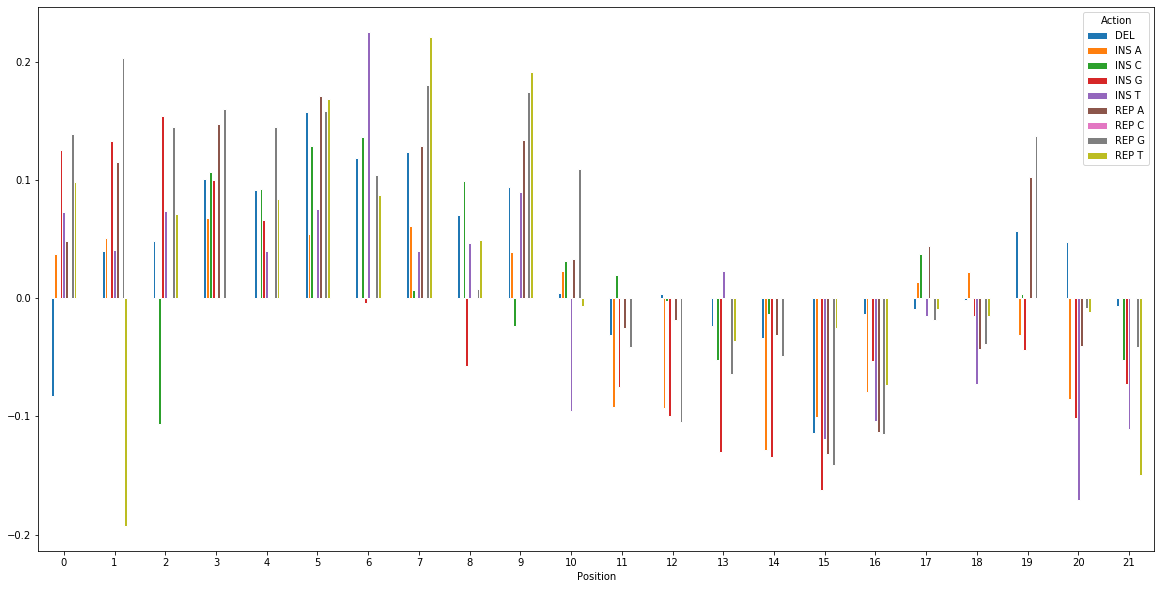

In [212]:
hist_plot(huber.coef_[:22*9])

In [215]:
dir(huber)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_preprocess_data',
 '_set_intercept',
 'alpha',
 'coef_',
 'epsilon',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'max_iter',
 'n_iter_',
 'outliers_',
 'predict',
 'scale_',
 'score',
 'set_params',
 'tol',
 'warm_start']

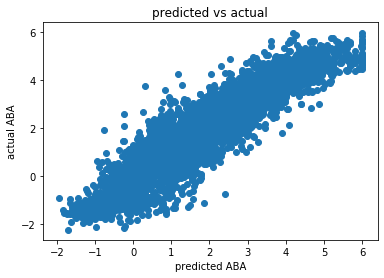

correlation is 0.9114008367547156


In [487]:
#X, y = create_matrix()
X = preprocessing.scale(X)
reg = linear_model.Ridge(alpha=1)
#X = np.append(X, X**2, axis=1)
reg.fit(X, y)
#This looks like the tightest regression so far
predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y)
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

In [488]:
X

array([[-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
         1.2463646 ,  1.16127982],
       [-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
         0.25090987,  0.19911012],
       [-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
         0.63013092,  0.56565115],
       ...,
       [-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
        -1.74000004, -1.72522971],
       [-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
         1.72039079,  1.61945599],
       [-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
         0.29831222,  0.24492748]])

In [284]:
reg.coef_

array([-1.14320079e-01, -1.26991803e-01, -1.51221568e-02, -3.52308345e-02,
       -7.87570792e-02,  0.00000000e+00,  8.89609340e-03, -5.07672014e-02,
       -1.20642610e-01, -6.28940031e-02,  0.00000000e+00,  2.81261805e-02,
       -4.66145649e-02,  1.57124015e-03,  0.00000000e+00,  1.04933989e-01,
       -3.06412296e-01,  2.75293234e-02,  0.00000000e+00, -1.51475091e-01,
        1.39683103e-01,  7.61989176e-02,  0.00000000e+00,  0.00000000e+00,
        1.72055889e-01,  3.62530485e-02,  3.52545856e-02, -6.04047828e-02,
       -2.89384197e-02, -2.40774194e-02,  0.00000000e+00,  2.25031339e-02,
        0.00000000e+00, -1.54122179e-02,  0.00000000e+00,  1.29944556e-02,
        0.00000000e+00, -1.32522917e-03, -1.37248458e-02, -1.99083709e-02,
        0.00000000e+00,  0.00000000e+00,  4.48841823e-02, -1.37359873e-02,
        4.44747068e-02, -6.62610367e-02,  1.39701941e-03,  0.00000000e+00,
       -1.17375317e-02,  5.49789742e-02,  0.00000000e+00,  4.21050015e-02,
       -7.38201312e-03,  

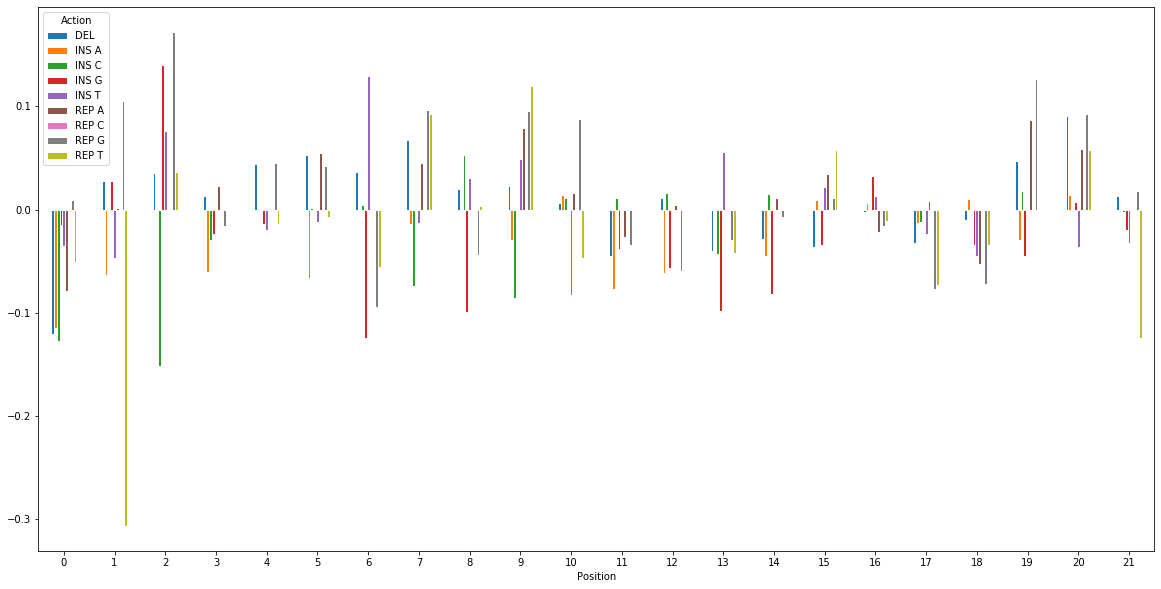

In [285]:
hist_plot(reg.coef_[:22*9])

In [258]:
predictions = []
vals = []
outliers= []
Outliers = []
for i in range(len(y)):
    val = y[i]
    vals.append(y)
    seq = big_table.loc[i]['sequence']
    prediction =  reg.predict([X[i]]).item()
    predictions.append(prediction)
    if abs(val-prediction) > 3:
        outliers.append(seq)
        Outliers.append(big_table.loc[i]['Sequence'])
        print(seq)

CTCACTAGAGAGGTTATCCGCTCA
GCATAGAGAGTTTATCCGCTCA
CCATAGAGAGGTATAGGGCTCA
CTCATAGAGAGGTTATCTCGCTCA
CCATGGAGAGGGTATCCGCTCA
GGTATCTCTCCAATACCGCTCA
CCATAGAAGGTTATCCCTCA
CCATAGAGAGGTTATTCCGCTACA
CCATAGAGAGGTTGATCCGCTCAT
CCATAGAGAAGTTATCCGTTCA


In [241]:
 reg.predict([X[0]]).item()

3.030201400997912

In [242]:
len(outliers)

100

In [257]:
for outlier in outliers:
    print(get_diff(perfect_sequence, outlier))
    print(perfect_sequence,outlier)

[(0, 'insert', 'T'), (2, 'insert', 'C')]
CCATAGAGAGGTTATCCGCTCA CTCACTAGAGAGGTTATCCGCTCA
[(0, 'replace', 'G'), (10, 'replace', 'T')]
CCATAGAGAGGTTATCCGCTCA GCATAGAGAGTTTATCCGCTCA
[(11, 'delete'), (14, 'insert', 'A'), (15, 'replace', 'G'), (16, 'replace', 'G')]
CCATAGAGAGGTTATCCGCTCA CCATAGAGAGGTATAGGGCTCA
[(0, 'insert', 'T'), (15, 'insert', 'T')]
CCATAGAGAGGTTATCCGCTCA CTCATAGAGAGGTTATCTCGCTCA
[(4, 'replace', 'G'), (11, 'replace', 'G')]
CCATAGAGAGGTTATCCGCTCA CCATGGAGAGGGTATCCGCTCA
[(0, 'delete'), (1, 'replace', 'G'), (2, 'replace', 'G'), (5, 'replace', 'T'), (6, 'replace', 'C'), (7, 'replace', 'T'), (8, 'replace', 'C'), (9, 'replace', 'T'), (10, 'replace', 'C'), (11, 'replace', 'C'), (12, 'replace', 'A'), (14, 'insert', 'A')]
CCATAGAGAGGTTATCCGCTCA GGTATCTCTCCAATACCGCTCA
[(7, 'delete'), (17, 'delete')]
CCATAGAGAGGTTATCCGCTCA CCATAGAAGGTTATCCCTCA
[(13, 'insert', 'T'), (19, 'insert', 'A')]
CCATAGAGAGGTTATCCGCTCA CCATAGAGAGGTTATTCCGCTACA
[(12, 'insert', 'G'), (21, 'insert', 'T')]
CCATAGA

In [260]:
for outlier in Outliers:
    print(outlier)

GGGAAUGGAUCCACAUCUACGAAUUCGUACUCACUAGAGAGGUUAUCCGCUCACCGAGAUCGGAAGAGCACACGUCUGAACUCCA
GGGAAUGGAUCCACAUCUACGAAUUCGUAGCAUAGAGAGUUUAUCCGCUCACCGAGAUCGGAAGAGCACACGUCUGAACUCCA
GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUAUAGGGCUCACCGAGAUCGGAAGAGCACACGUCUGAACUCCA
GGGAAUGGAUCCACAUCUACGAAUUCGUACUCAUAGAGAGGUUAUCUCGCUCACCGAGAUCGGAAGAGCACACGUCUGAACUCCA
GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGAGGGUAUCCGCUCACCGAGAUCGGAAGAGCACACGUCUGAACUCCA
GGGAAUGGAUCCACAUCUACGAAUUCGUAGGUAUCUCUCCAAUACCGCUCACCGAGAUCGGAAGAGCACACGUCUGAACUCCA
GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAAGGUUAUCCCUCACCGAGAUCGGAAGAGCACACGUCUGAACUCCA
GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUUCCGCUACACCGAGAUCGGAAGAGCACACGUCUGAACUCCA
GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUGAUCCGCUCAUCCGAGAUCGGAAGAGCACACGUCUGAACUCCA
GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAAGUUAUCCGUUCACCGAGAUCGGAAGAGCACACGUCUGAACUCCA


In [262]:
PERFECT_SEQ

'GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCCGCUCACCGAGAUCGGAAGAGCACACGUCUGAACUCCA'

In [288]:
X

array([[-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
         0.25090987,  0.19911012],
       [-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
         0.25090987,  0.19911012],
       [-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
         0.25090987,  0.19911012],
       ...,
       [-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
        -0.36532426, -0.39651899],
       [-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
        -0.60233736, -0.62560708],
       [-0.1208928 , -0.1208928 , -0.1208928 , ..., -0.26261287,
         0.01389678, -0.02997797]])

In [489]:
def r_squared(model, X, y, train_size=100, exp=1):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    train_x = X[:train_size]
    test_x = X[train_size:]
    train_y = y[:train_size]
    test_y = y[train_size:]
    
    
    model.fit(train_x, np.sign(train_y) * (np.abs(train_y)) ** exp)
    #This looks like the tightest regression so far
    predicted_output = test_x @ reg.coef_ + reg.intercept_
    
    corr, p_value = pearsonr(vhinge(predicted_output, exp=exp), np.sign(test_y) * (np.abs(test_y)) ** exp)
    #display(vhinge(predicted_output, exp=exp), np.sign(test_y) * (np.abs(test_y)) ** exp)
    #print("correlation is",corr)
    return corr**2

In [497]:
r_squared(reg, X, y, train_size=4000,exp=1.6)

0.8276906187384557

In [322]:
min(y**1.5)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


0.0

In [328]:
reg.fit(X, np.sign(y) * (np.abs(y)) ** 1.5)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [327]:
np.power(y,1.5)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


array([2.63938266, 5.14065027, 5.35750459, ..., 5.38436028, 8.49673147,
       3.01318693])

In [377]:
max_sum = 0
max_exp = 0
for i in np.linspace(1,2,201):
    cur_sum = 0
    for j in range(10):
        cur_sum += r_squared(reg, X, y, train_size=4000,exp=i)
    if cur_sum/10 > max_sum:
        max_sum = cur_sum/10
        max_exp = i
        print(max_sum, max_exp)

0.8159714267760719 1.0
0.8189089980019562 1.02
0.8205060880271647 1.045
0.8231490612582076 1.05
0.8250096255120631 1.205
0.8263695755665885 1.26
0.8279409109430764 1.2650000000000001
0.8282413238748878 1.275
0.8326570985902103 1.45


In [379]:
max_sum**.5

0.9125004649808187

In [380]:
min(abs(y))

0.0

In [382]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [390]:
from keras import layers
from keras import models

In [392]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
Total params: 832
Trainable params: 832
Non-trainable params: 0
_________________________________________________________________


In [507]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
model.add(layers.MaxPooling2D((3, 1)))
model.add(layers.Conv2D(32, (9, 1), activation='relu'))
#model.add(layers.Conv2D(32, (9, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
model.add(layers.MaxPooling2D((3, 1)))
model.add(layers.Conv2D(64, (27, 1), activation='relu'))
model.add(layers.MaxPooling2D((3, 1)))
#model.add(layers.Conv2D(54, (54, 1), activation='relu'))
#model.add(layers.MaxPooling2D((3, 1)))
#model.summary()
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 341, 1, 16)        64        
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 113, 1, 16)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 105, 1, 32)        4640      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 35, 1, 32)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 9, 1, 64)          55360     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 3, 1, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 192)             

In [466]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

In [502]:
X_ = X.reshape((len(X), len(X[0]), 1, 1))
y_ = y.reshape(len(y), 1)

In [499]:
y_

array([[2.63411008],
       [1.70061649],
       [2.14783964],
       ...,
       [2.82420759],
       [0.14578746],
       [2.66829998]])

In [403]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [508]:
batch_size = 100
epochs = 80

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_, y_,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1
          )

Epoch 1/80
4929/4929 [==============================] - 1s 205us/step - loss: 1.6281 - accuracy: 0.0000e+00
Epoch 2/80
4929/4929 [==============================] - 1s 162us/step - loss: 1.1068 - accuracy: 2.0288e-04
Epoch 3/80
4929/4929 [==============================] - 1s 159us/step - loss: 1.0041 - accuracy: 2.0288e-04
Epoch 4/80
4929/4929 [==============================] - 1s 193us/step - loss: 0.8817 - accuracy: 2.0288e-04
Epoch 5/80
4929/4929 [==============================] - 1s 177us/step - loss: 0.7955 - accuracy: 2.0288e-04
Epoch 6/80
4929/4929 [==============================] - 1s 157us/step - loss: 0.7830 - accuracy: 2.0288e-04
Epoch 7/80
4929/4929 [==============================] - 1s 176us/step - loss: 0.6705 - accuracy: 2.0288e-04
Epoch 8/80
4929/4929 [==============================] - 1s 168us/step - loss: 0.6437 - accuracy: 2.0288e-04
Epoch 9/80
4929/4929 [==============================] - 1s 171us/step - loss: 0.5731 - accuracy: 2.0288e-04
Epoch 10/80
4929/4929 [=====

4929/4929 [==============================] - 1s 164us/step - loss: 0.1333 - accuracy: 2.0288e-04
Epoch 77/80
4929/4929 [==============================] - 1s 183us/step - loss: 0.1386 - accuracy: 2.0288e-04
Epoch 78/80
4929/4929 [==============================] - 1s 176us/step - loss: 0.1340 - accuracy: 2.0288e-04
Epoch 79/80
4929/4929 [==============================] - 1s 191us/step - loss: 0.1384 - accuracy: 2.0288e-04
Epoch 80/80
4929/4929 [==============================] - 1s 163us/step - loss: 0.1424 - accuracy: 2.0288e-04


In [419]:
test_loss, test_acc = model.evaluate(X_, y_)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

4929/4929 [==============================] - 1s 103us/step
Test loss: 0.47273120139573405
Test accuracy: 0.00020288091036491096


In [420]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_add_unique_metric_name',
 '_base_init',
 '_build_input_shape',
 '_built',
 '_cache_output_metric_attributes',
 '_check_trainable_weights_consistency',
 '_collected_trainable_weights',
 '_compile_metric_functions',
 '_compile_metrics',
 '_compile_weighted_metrics',
 '_compute_previous_mask',
 '_expects_training_arg',
 '_feed_input_names',
 '_feed_input_shapes',
 '_feed_inputs',
 '_feed_loss_fns',
 '_feed_output_names',
 '_feed_output_shapes',
 '_feed_outputs',
 '_feed_sample_weight_modes',
 '_feed_sample_weights',
 '_feed_targets',
 '_function_kwargs',


In [430]:
model.predict(X_)

array([[2.003289  ],
       [3.0145607 ],
       [2.7025666 ],
       ...,
       [3.4947839 ],
       [3.399231  ],
       [0.96322435]], dtype=float32)

In [423]:
len(X_[0])

343

In [429]:
X_.shape

(4929, 343, 1, 1)

In [431]:
y_

array([[1.90986017],
       [2.978599  ],
       [3.06178742],
       ...,
       [3.07201082],
       [4.16390931],
       [2.0861749 ]])

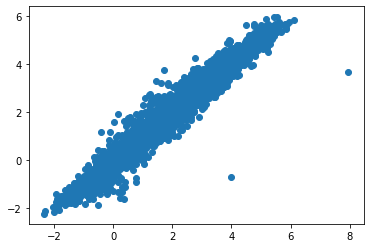

In [509]:
plt.scatter(model.predict(X_), y_)

In [510]:
corr, p_value = pearsonr((model.predict(X_)).reshape(len(X_)), y)

In [511]:
corr

0.9777451503674226

In [ ]:
pearsonr(vhinge(predicted_output), y)

In [532]:
#returns a model
def train(X, y):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    y_ = y.reshape(len(y), 1)
    
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Conv2D(32, (9, 1), activation='relu'))
    model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Conv2D(64, (27, 1), activation='relu'))
    model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='linear'))
    model.summary()
    
    batch_size = 100
    epochs = 100
    

    model.compile(loss='mean_squared_error',
                  optimizer='sgd')

    model.fit(X_, y_,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1
              )
    return model

def fit(model, X, y):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    plt.scatter(vhinge(model.predict(X_)), y)
    plt.show()
    corr, p_value = pearsonr(vhinge((model.predict(X_)).reshape(len(X_))), y)
    print("corr is", corr)

In [531]:
X_train = X[:3500]
X_test = X[3500:]

y_train = y[:3500]
y_test = y[3500:]

model = train(X_train, y_train)
fit(model, X_test, y_test)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 341, 1, 16)        64        
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 113, 1, 16)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 105, 1, 32)        4640      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 35, 1, 32)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 9, 1, 64)          55360     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 3, 1, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 192)             

3500/3500 [==============================] - 1s 188us/step - loss: 0.1424
Epoch 80/100
3500/3500 [==============================] - 1s 179us/step - loss: 0.1141
Epoch 81/100
3500/3500 [==============================] - 1s 194us/step - loss: 0.1167
Epoch 82/100
3500/3500 [==============================] - 1s 174us/step - loss: 0.1308
Epoch 83/100
3500/3500 [==============================] - 1s 172us/step - loss: 0.1140
Epoch 84/100
3500/3500 [==============================] - 1s 163us/step - loss: 0.1074
Epoch 85/100
3500/3500 [==============================] - 1s 154us/step - loss: 0.1072
Epoch 86/100
3500/3500 [==============================] - 1s 158us/step - loss: 0.1161
Epoch 87/100
3500/3500 [==============================] - 1s 155us/step - loss: 0.1000
Epoch 88/100
3500/3500 [==============================] - 1s 156us/step - loss: 0.1132
Epoch 89/100
3500/3500 [==============================] - 1s 168us/step - loss: 0.1089
Epoch 90/100
3500/3500 [==============================] 

TypeError: fit() takes 2 positional arguments but 3 were given

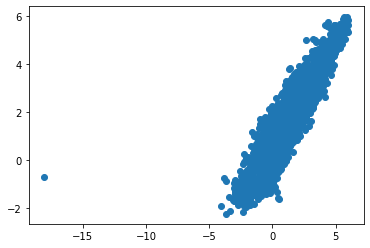

corr is 0.9192901203288656


In [533]:
corr = fit(model, X_train, y_train)

In [451]:
0.95529**2

0.9125789840999999

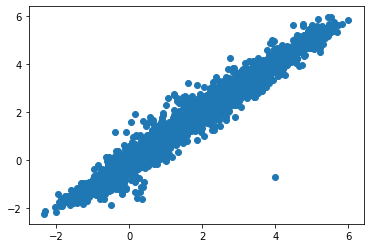

corr is 0.9783372898080087


In [520]:
fit(X_train, y_train)

In [522]:
len(X_test)

1429

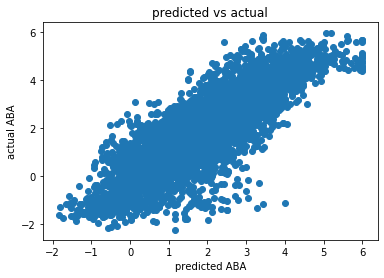

correlation is 0.8319195379566576


In [455]:
reg = linear_model.LinearRegression()
reg.fit(X_add, y)
#This looks like the tightest regression so far
predicted_output = X_add @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y)
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

In [461]:
X

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
        -11.10000038, -11.10000038],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        -13.19999981, -13.19999981],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        -12.39999962, -12.39999962],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        -17.39999962, -17.39999962],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        -10.10000038, -10.10000038],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        -13.10000038, -13.10000038]])